# IMPORT LIBRAIRIES

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

# from utils.load_filters_for_primer2 import get_filters_multi_scale
from utils.load_custom_filters_for_primer import get_filters_multi_scale

np.set_printoptions(precision=3, suppress=True)

# LOAD DATA

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
lmk_pos = np.load("_lmk_pos_train65.npy")
print("Loaded {} primers".format(len(lmk_pos)))
num_digits = int(np.amax(lmk_pos[:, 0]))
print("num_digits:", num_digits)
n_cat = int(np.amax(lmk_pos[:, 3]))
print("n_cat:", n_cat)

Loaded 323 primers
num_digits: 64
n_cat: 12


## display digits

/Users/michaelstettler/PycharmProjects/BVS/BVS/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


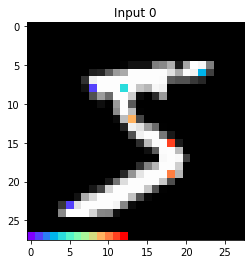

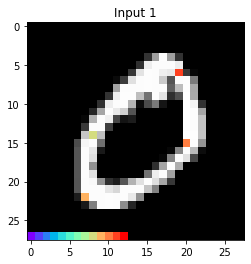

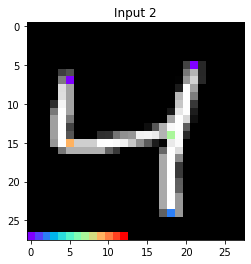

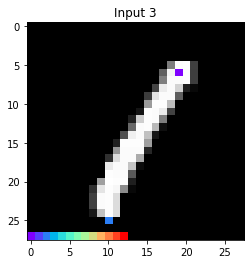

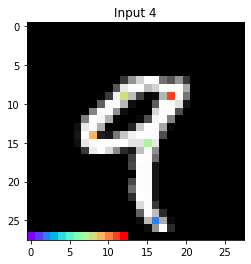

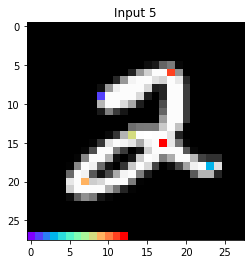

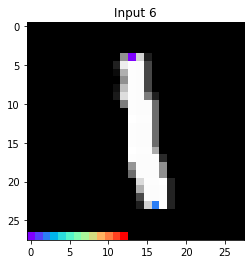

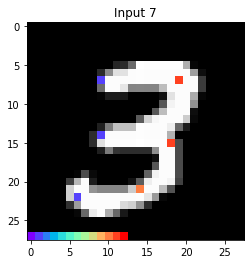

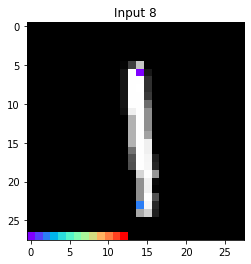

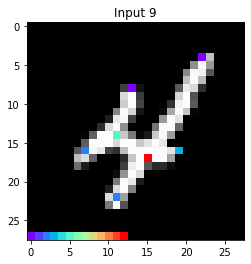

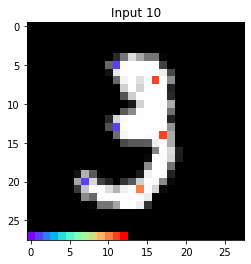

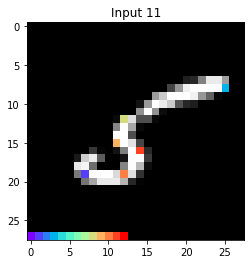

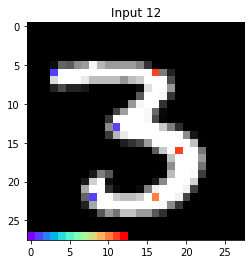

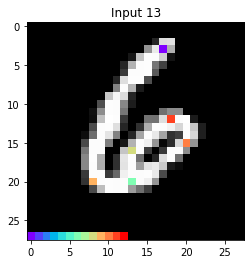

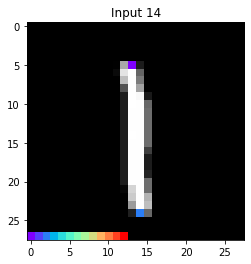

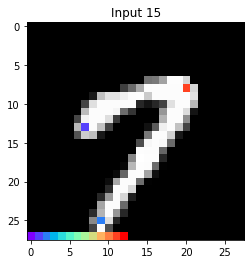

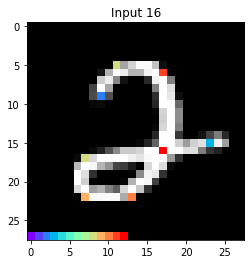

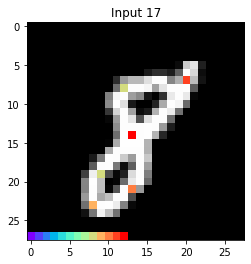

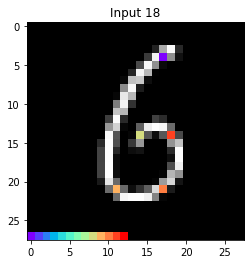

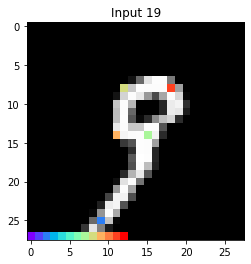

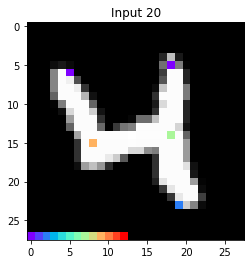

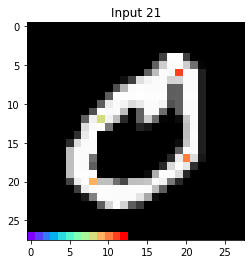

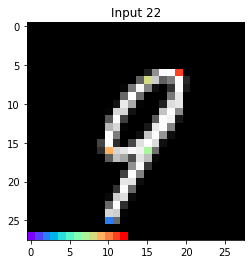

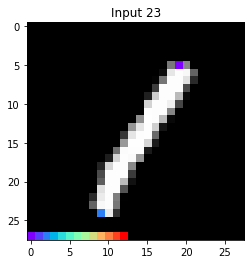

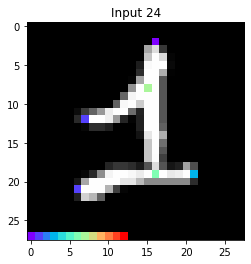

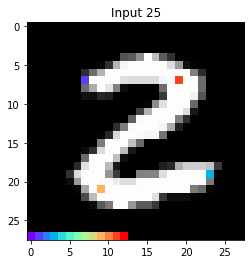

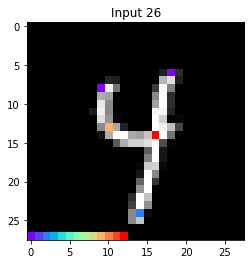

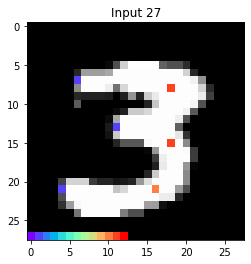

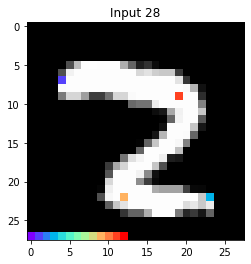

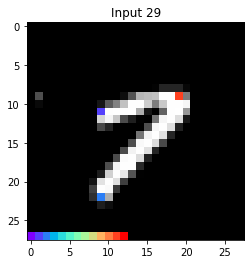

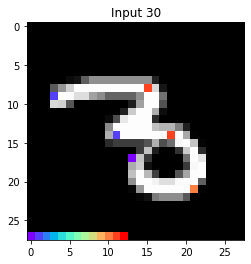

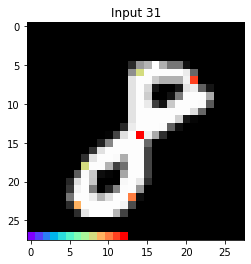

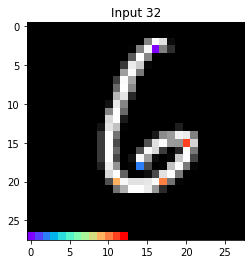

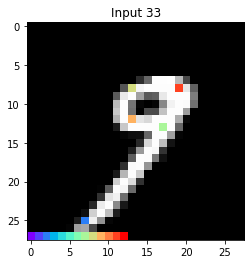

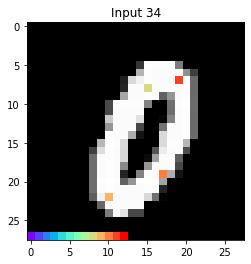

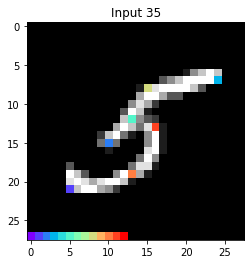

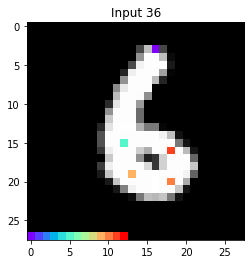

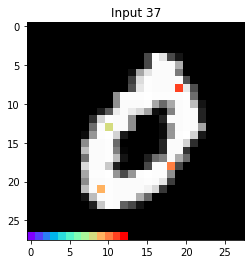

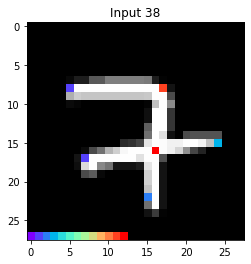

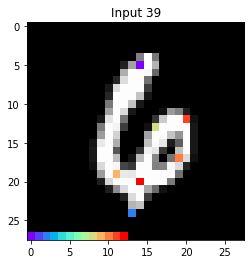

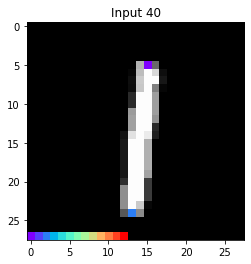

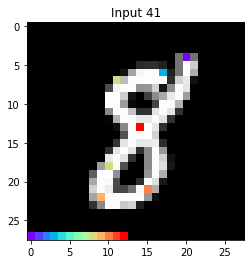

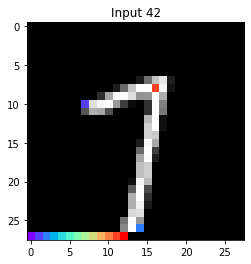

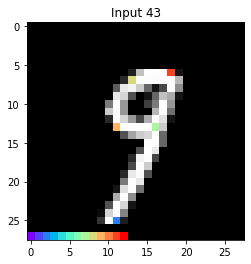

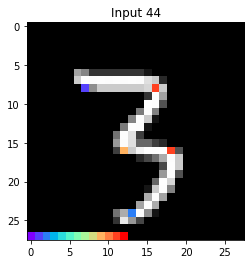

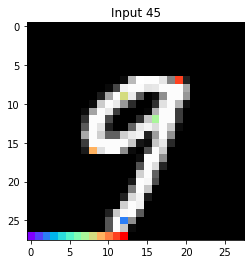

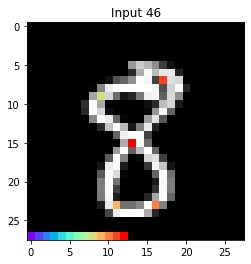

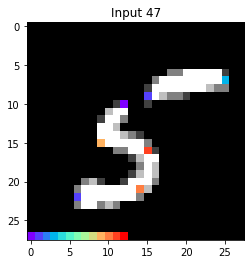

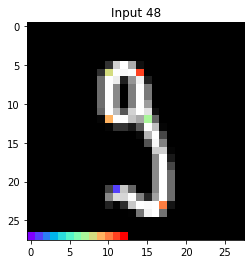

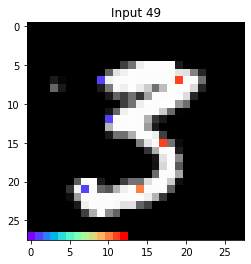

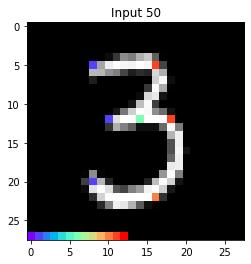

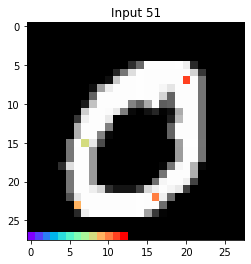

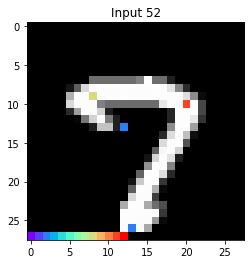

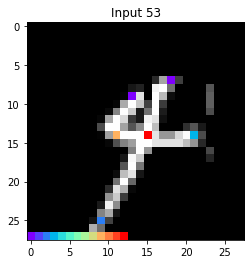

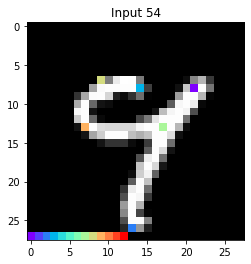

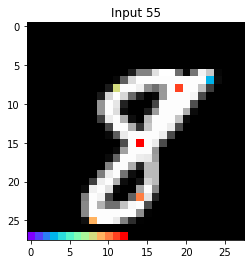

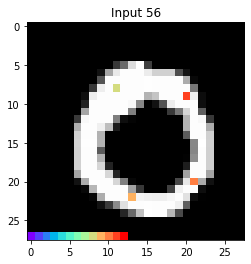

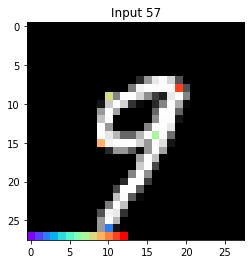

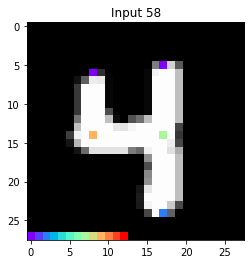

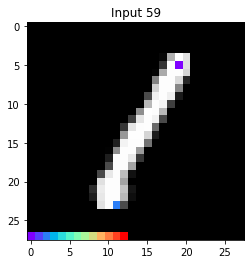

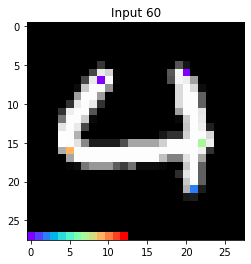

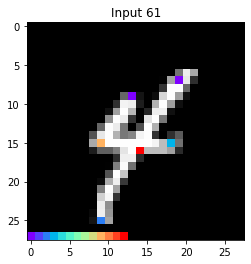

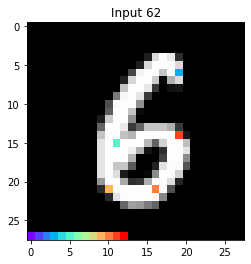

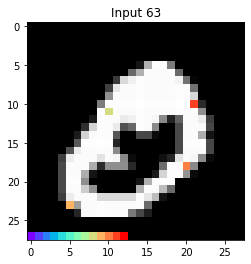

In [46]:
colors = cm.rainbow(np.linspace(0, 1, n_cat + 1))

# plot primers on digit
for d in range(num_digits):
    plt.figure()

    test_image = x_train[d]
    rgb_im = np.repeat(np.expand_dims(test_image, axis=2), 3, axis=2)

    # retrieve primers
    primers = lmk_pos[lmk_pos[:, 0] == d]

    for primer in primers:
        color = colors[int(primer[3])]
        rgb_im[np.round(primer[2]).astype(int), np.round(primer[1]).astype(int)] = color[:3] * 255

    # plot legend
    for i in range(n_cat + 1):
        color = colors[i]
        rgb_im[-1, i] = color[:3] * 255

    plt.title("Input {}".format(d))
    plt.imshow(rgb_im)

# TRAIN LMK DETECTOR

In [57]:
def create_patch(img, lmk, filt_size=(9, 9)):
    pad_x = int(filt_size[0] / 2)
    pad_y = int(filt_size[1] / 2)

    # define start and stop
    start_x = int(np.round(lmk[2]))-pad_x
    end_x = int(np.round(lmk[2]))+pad_x+1
    start_y = int(np.round(lmk[1]))-pad_y
    end_y = int(np.round(lmk[1]))+pad_y+1

    # define filter for primer
    patch = img[np.maximum(start_x, 0):end_x, np.maximum(start_y, 0):end_y]
    # print(patch)

    # add zeros if patch is smaller than the dimension
    if start_x < 0:
        zeros_patch = np.zeros((filt_size[0] - np.shape(patch)[0], np.shape(patch)[1]))
        patch = np.vstack([zeros_patch, patch])
    elif end_x > np.shape(img)[0]:
        zeros_patch = np.zeros((end_x - np.shape(img)[0], np.shape(patch)[1]))
        patch = np.vstack([patch, zeros_patch])
    if start_y < 0:
        zeros_patch = np.zeros((np.shape(patch)[0], filt_size[1] - np.shape(patch)[1]))
        patch = np.hstack([zeros_patch, patch])
    elif end_y > np.shape(img)[1]:
        zeros_patch = np.zeros((np.shape(patch)[0], end_y - np.shape(img)[1]))
        patch = np.hstack([patch, zeros_patch])

    return patch

In [58]:
def get_RBF_kernels(lmks, filt_size=(9, 9)):
    filters = [[], [], [], [], [], [] ,[], [], [], [], [], [], []]
    for lmk in lmks:
        print("lmk", lmk)
        lmk_idx = int(lmk[0])
        lmk_type = int(lmk[3])

        # create patch from MNIST image
        img = np.array(x_train[lmk_idx] / 255.)
        patch = create_patch(img, lmk, filt_size=filt_size)

        filters[lmk_type].append(patch)

    return filters

In [59]:
filters = get_RBF_kernels(lmk_pos)

for type in range(len(filters)):
    print("{} filter for type {}".format(len(filters[type]), type))

lmk [0. 8. 8. 1.]
lmk [ 0.     4.944 23.     1.   ]
lmk [ 0.    22.497  6.     3.   ]
lmk [ 0. 12.  8.  4.]
lmk [ 0. 13. 12.  9.]
lmk [ 0. 18. 19. 10.]
lmk [ 0. 18. 15. 11.]
lmk [ 1.     8.    14.022  8.   ]
lmk [ 1.  7. 22.  9.]
lmk [ 1. 20. 15. 10.]
lmk [ 1. 19.  6. 11.]
lmk [2. 5. 7. 0.]
lmk [ 2.    21.     5.487  0.   ]
lmk [ 2.    18.    24.492  2.   ]
lmk [ 2. 18. 14.  7.]
lmk [ 2.  5. 15.  9.]
lmk [ 3.    18.505  5.506  0.   ]
lmk [ 3.     9.763 24.724  2.   ]
lmk [ 4. 16. 25.  2.]
lmk [ 4. 15. 15.  7.]
lmk [ 4. 12.  9.  8.]
lmk [ 4.     8.    14.486  9.   ]
lmk [ 4. 18.  9. 11.]
lmk [5.    9.497 9.    1.   ]
lmk [ 5. 23. 18.  3.]
lmk [ 5. 13. 14.  8.]
lmk [ 5.  7. 20.  9.]
lmk [ 5. 18.  6. 11.]
lmk [ 5. 17. 15. 12.]
lmk [ 6.    13.317  4.333  0.   ]
lmk [ 6.    16.    22.519  2.   ]
lmk [7.    8.983 7.    1.   ]
lmk [ 7.     8.982 14.237  1.   ]
lmk [ 7.     5.68  21.653  1.   ]
lmk [ 7. 14. 21. 10.]
lmk [ 7. 19.  7. 11.]
lmk [ 7. 18. 15. 11.]
lmk [ 8.    13.657  5.506  0.   ]


In [ ]:
def predict_RBF(img, filters):
    for f_type in range(len(filters)):
        for filter in range(filters):


    kernels.append(np.exp(-np.linalg.norm(diff_, ord=2, axis=1) ** 2 / 2 / self.sigma ** 2))